# Physicochemical Properties of Protein Tertiary Structure

Author: **Marcin Sikorski**<br>
Date: February, 2023

**Abstract**<br>
One of the most important topics of research in the field of molecular biology is the three-dimensional reconstruction of macromolecules like proteins. The study of protein tertiary structure contributes to protein function and also used for medicine design and drug discovery. The prediction of protein structure is one of the most challenging tasks in bioinformatics. This is mainly caused by its complex geometry and twisted structure. Correctly predicting the spinal backbone of a tertiary structure presents a great difficulty to determinate the flexible torsion angles, as well as angles of the individual side chains. A medium sized protein has on average hundreds of variables in total. This caused in recent years soft computing technologies as the best possibilities to solve this type of NP-complete problems.

The subject of this notebook is to estimate residue size for each protein (a regression task). To determine the tertiary structure of proteins, we will develop machine learning algorithms.

**Data source:** [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure), dataset is taken from CASP 5-9

**Notebook Content:**
1. Loading Libraries and Importing Dataset
2. Data Exploration and Cleansing
3. Class Categorization and Dimensionality Reduction
4. Stratified Sampling and Rescaling Data
5. Developing Regression Models<br>
    5a. Artificial Neural Network<br>
    5b. Random Forest<br>
    5c. Multi-layer Perceptron<br>
    5d. Gradient Boosting<br>
6. Visualizing Model Performance
7. Summary

### 1. Loading Libraries and Importing Dataset

We will load the data from an URL address. The function will firstly check if the CSV file exists in the main directory. If not, then it will download it every time directly from the website.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# open dataset from URL
def get_dataset(dataset_url):
    """:dataset_url: string"""
    import requests, os
    
    # if CSV file does not exist in local dir, then download from URL
    if os.path.exists('./CASP.csv') is False:
        r = requests.get(dataset_url, allow_redirects=True)
        open('CASP.csv', 'wb').write(r.content)
    df = pd.read_csv('CASP.csv', header=0)
    
    # remove duplicated rows
    df = df.drop_duplicates()
    return df

download_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv'

df = get_dataset(dataset_url=download_url)
df.head(10)

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147
5,1.700,5117.30,1120.99,0.21905,51.6732,6.727227e+05,79.5911,3234.21,15,41.2382
6,9.314,5924.16,1625.27,0.27434,70.2103,8.285145e+05,76.8064,2821.40,70,39.4964
7,1.985,6882.15,1791.22,0.26027,77.2501,9.165165e+05,96.6785,3490.88,74,37.4203
8,1.915,12090.00,4190.74,0.34662,129.0020,1.687508e+06,186.3090,4262.78,39,30.3916
9,1.495,7400.24,1881.95,0.25430,82.9320,1.023846e+06,104.6970,3852.40,26,35.4140


The header contains abbreviated (symbolic) properties of columns. The target data to predict is the RMSD (root mean square deviation). The following table has more information for each attribute:

| **Feature** |                     **Description**                     |
|:-----------:|:-------------------------------------------------------:|
| RMSD        | size of the residue                                     |
| F1          | total surface area                                      |
| F2          | non-polar exposed area                                  |
| F3          | fractional area of exposed non-polar residue            |
| F4          | fractional area of exposed non-polar part of residue    |
| F5          | molecular mass weighted exposed area                    |
| F6          | average deviation from standard exposed area of residue |
| F7          | Euclidian distance                                      |
| F8          | secondary structure penalty                             |
| F9          | spacial distribution constraints (N, K value)           |

**Introduction to Protein Structure**<br>
Proteins are large biomolecules and macromolecules that comprise one or more long chains of amino acid residues. They are constructed of several polypeptide chains of amino acids, which fold into four complex tertiary structures.

A polypeptide chain is formed by amino acids linked together by peptide bonds and it is known as primary structure. One or more polypeptide chains twisted in a 3D shape form a protein secondary structure. Any multiple folds, loops and curves are considered polypeptide chain and are known as tertiary structures. A protein macromolecule formed by interactions between multiple polypeptide chains, i.e, sets of tertiary structures are called protein quaternary structure.

![proteins](https://microbenotes.com/wp-content/uploads/2018/05/Protein-Structure-Primary-Secondary-Tertiary-and-Quaternary.jpg)
<p style='text-align: center;'>Four levels of organisation of protein structure. Source: https://microbenotes.com/protein-structure-primary-secondary-tertiary-and-quaternary/</p>


### 2. Data Exploration and Cleansing

The dataset is loaded and ready for further investigation. We will summarize it, get a good understanding, and see what the data can tell us before building machine learning models. We will also check feature distribution, patterns, and its completness. At this stage we will perform possible data adjustments and cleansing.

In [2]:
# display data types, count non-null values, and skewness
def dataframe_summary(): 
    # lists
    var_list = df.columns.to_list()
    dtype_list = []
    non_null_list = []
    skew_list = []
    
    # loop through columns
    for col in df.columns:
        dtype_list.append(df[col].dtype)
        non_null_list.append(df[col].notnull().sum())
        skew_list.append(df[col].skew(skipna=True))
    
    # stack lists into dictionary
    dictionary = {'Variable': var_list, 'Data type': dtype_list, 'Non-null values': non_null_list, 'Skewness': skew_list}
    
    return pd.DataFrame(dictionary).style.hide_index()
    
dataframe_summary()

Variable,Data type,Non-null values,Skewness
RMSD,float64,44019,0.552819
F1,float64,44019,1.094760
F2,float64,44019,1.193430
F3,float64,44019,0.239840
F4,float64,44019,1.222133
F5,float64,44019,1.060663
F6,float64,44019,1.119127
F7,float64,44019,21.013368
F8,int64,44019,1.686218
F9,float64,44019,-0.472854


All variables are numeric and do not have NaN values. There are no qualitative columns in this dataset.

The <code>skewness</code> column show a positive (right) or negative (left) skew. Values closer to zero show less skew and have more normal distribution. Based on given scores, <code>F3</code> seems to be the most valuable predictor in this data. We can eliminate <code>F7</code> column in further analysis. Instead of dropping it, we will apply a power transform featurewise to make data more Gaussian-like.

In [3]:
# perform power transformation on 'F7'
def power_transform():
    from sklearn.preprocessing import PowerTransformer
    
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    df['F7'] = pt.fit_transform(df['F7'].values.reshape(-1, 1))
    
power_transform()

# display skewness
df['F7'].skew()

0.04534119289750979

In [4]:
# descriptive statistics of dataset
df.describe().round(2)

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,44019.00,44019.00,44019.00,44019.00,44019.00,44019.00,44019.00,44019.00,44019.00,44019.00
mean,7.80,9874.50,3019.46,0.30,103.50,1368753.22,145.67,-0.00,70.10,34.52
std,6.14,4054.02,1465.35,0.06,55.30,563505.02,69.87,1.00,56.49,5.98
min,0.00,2392.05,403.50,0.09,10.31,319490.22,31.97,-22.09,0.00,15.23
25%,2.31,6940.70,1979.52,0.26,63.61,954218.93,94.79,-0.55,31.00,30.43
50%,5.09,8902.58,2671.03,0.30,87.78,1238021.98,126.22,0.05,54.00,35.30
75%,13.47,12124.45,3789.58,0.34,133.61,1690883.28,181.45,0.64,91.00,38.87
max,21.00,40034.90,15312.00,0.58,369.32,5472011.41,598.41,10.95,350.00,55.30


There are RMSD values equal zero in the dataset (in minimum row). According to a [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2374114/) from 2001, zero is an acceptable value and is not incorrect:

>The RMSD is 0 for identical structures, and its value increases as the two structures become more different. RMSD values are considered as reliable indicators of variability when applied to very similar proteins, like alternative conformations of the same protein.

No further operations will be made on this column.

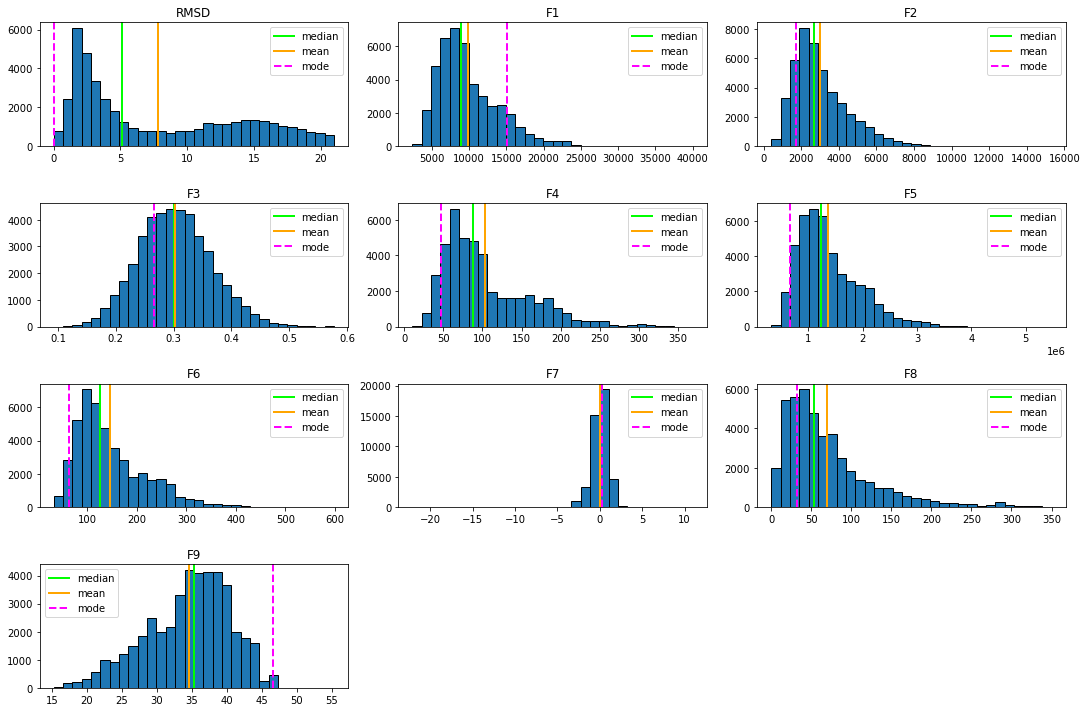

In [5]:
# plot histogram for each column
def plot_histograms():
    # plot size
    plt.subplots(figsize=(15, 10))
    
    count = 1
    # plot histograms
    for pred in df.columns:
        plt.subplot(4, 3, count)
        plt.hist(x=df[pred], bins=30, edgecolor='black')
        
        # plot median, mean, mode
        plt.axvline(x=df[pred].median(), ls='solid', linewidth=2, color='lime', label='median')
        plt.axvline(x=df[pred].mean(), ls='solid', linewidth=2, color='orange', label='mean')
        plt.axvline(x=df[pred].mode()[0], ls='--', linewidth=2, color='magenta', label='mode')
        plt.title(pred)
        plt.legend(loc='best')
        #plt.grid(True)
        count += 1
    plt.tight_layout()
    plt.show()

plot_histograms()

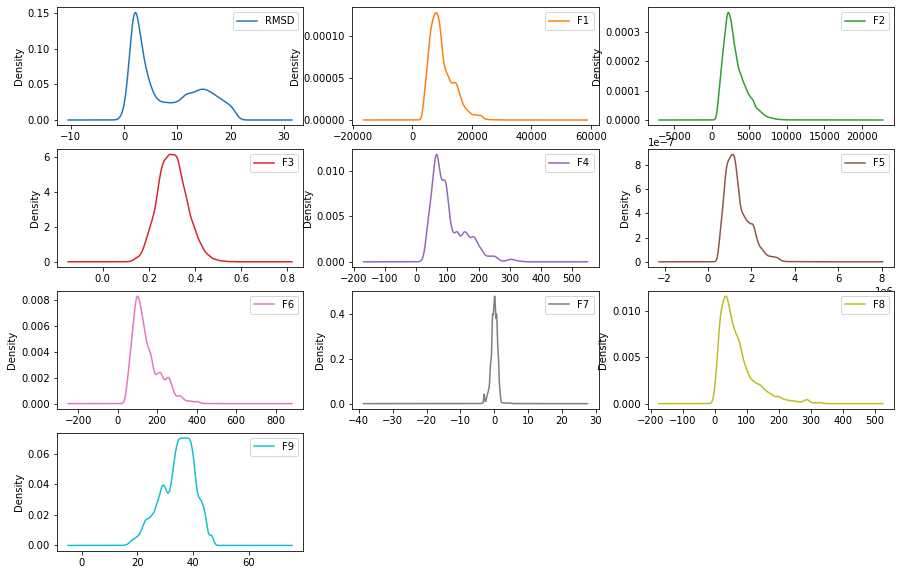

In [6]:
# density plots
df.plot(figsize=(15, 10), kind='density', subplots=True, layout=(4, 3), sharex=False, sharey=False)
plt.show()

Unlike histograms, density plots determine the shape of the distribution more efficiently. By looking at the shape of each data distribution, performing a regression task is possible. Most features follow a gamma or beta distribution. Scaling of the variables is highly recommended. The characteristics might contain outliers.

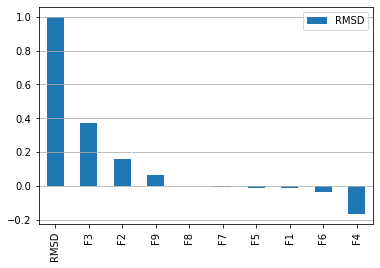

In [7]:
# plot correlations and order descending
pd.DataFrame(df.corr(method='pearson')['RMSD'].sort_values(ascending=False)).plot.bar()
plt.grid(axis='y')
plt.show()

Overall, the correlations between independent variables and <code>RMSD</code> are not strong. <code>F3</code> is still the best predictor. There are not much characteristics to choose and developing an accurate regression model will be tricky. In case in which we have low correlations between the target variable and the other attributes, Aurélien Géron suggests in his [book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) to generate extra features from combinations of characteristics. We will display a scatter matrix to check for more patterns between other features.

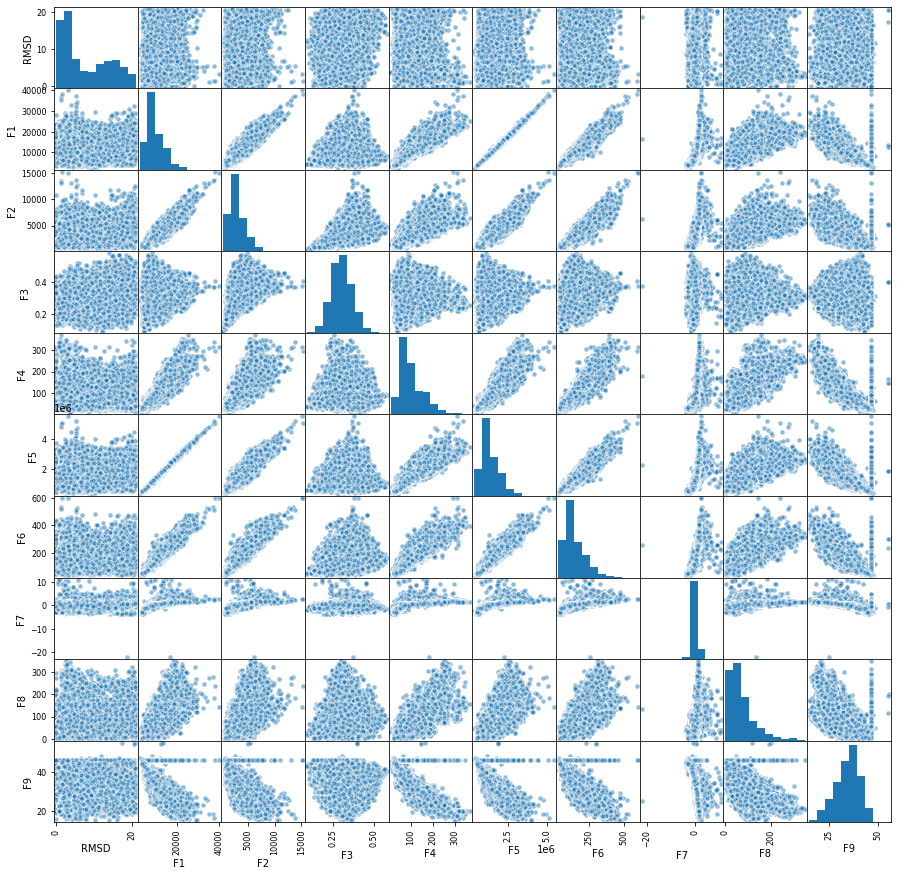

In [8]:
# matrix of scatter plots
pd.plotting.scatter_matrix(frame=df, figsize=(15, 15), edgecolors='w', s=100)
plt.show()

* Although the correlations between variables and target data are not strong, some of the features are still very well correlated with each other. These features are: <code>F1</code>, <code>F2</code>, <code>F4</code>, <code>F5</code>, and <code>F6</code>. It is recommended to apply dimensionality reduction on this data.
* If we look closely at feature <code>F7</code>, we can spot outliers. We will drop these observations.
* Attribute <code>F9</code> has artificially capped values (in linear form). We will also get rid of these decoys.

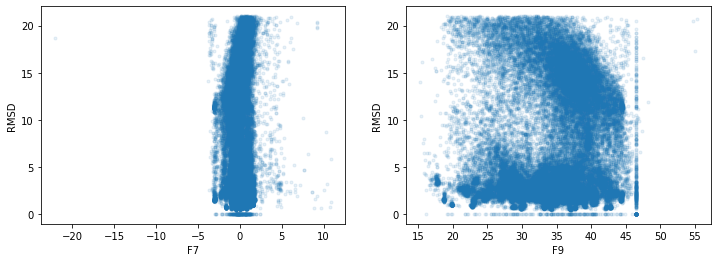

In [9]:
# plot 'F7' and 'F9' distribution
def plot_attributes():
    plt.figure(figsize=(12, 4))
    
    for i, var in enumerate(['F7', 'F9']):   
        plt.subplot(1, 2, i+1)
        plt.scatter(x=df[var], y=df['RMSD'], marker='.', alpha=0.1)
        plt.xlabel(var)
        plt.ylabel('RMSD')
    plt.show()

plot_attributes()

In [10]:
# eliminate outliers
df = df.query('F7 > -5')
df = df.query('F9 < 46')

# display final shape
def dataframe_shape():
    print('Number of decoys: {}'.format(df.shape[0]))
    print('Number of attributes: {}'.format(df.shape[1]))
    
dataframe_shape()

Number of decoys: 43548
Number of attributes: 10


### 3. Class Categorization and Dimensionality Reduction

We will perform stratified sampling later on, which will require a class feature. This means we need to create a dummy, categorical feature, to complete this task because our dataset contains only continuous predictors. In most cases, it is advisable to use the feature with the highest correlation with the target variable as the categorizing attribute, in our case <code>F3</code>, which is the fractional area of the non-polar amino acid chains that are exposed in the protein. Aurélien Géron advises to set at least five different classes.

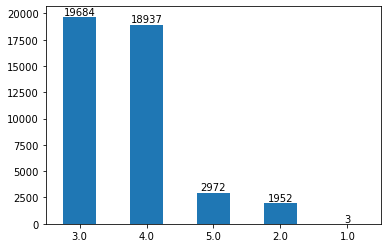

In [11]:
# create new categorical attribute
def categorical_feature():
    df['F3_cat'] = np.ceil(df['F3'] * 10)
    df['F3_cat'].where(cond=df['F3_cat'] < 5.0, other=5.0, inplace=True)
    
categorical_feature()

# display quantity of labels
def bar_plot():
    # create list of values
    list_values = df['F3_cat'].value_counts().tolist()
    
    # bar plot of categories
    df['F3_cat'].value_counts().plot.bar()
    plt.xticks(rotation=0)
    
    # add count values from list
    for i, v in enumerate(list_values):
        plt.text(x=i, y=v, s=str(v), ha='center', va='bottom')
    plt.show()
    
bar_plot()

In [12]:
# check proportions for each category
print(df['F3_cat'].value_counts() / len(df))

# sum all proportions - should be equal 1.00
print('\nSum of proportions:', pd.Series(df['F3_cat'].value_counts() / len(df)).sum())

3.0    0.452007
4.0    0.434853
5.0    0.068247
2.0    0.044824
1.0    0.000069
Name: F3_cat, dtype: float64

Sum of proportions: 1.0


Previously, we discovered multicollinearity between the features on scatter matrix. Some of the relationships between variables are moderate and even strong, which means that we should apply dimensionality reduction. We will implement the PCA (principal component analysis) and LDA (linear discriminant analysis) algorithms to carry out a linear dimensionality reduction of our original dataset. Their results can often reveal relationships that were previously unsuspected, thereby allowing interpretations that would not ordinarily result.

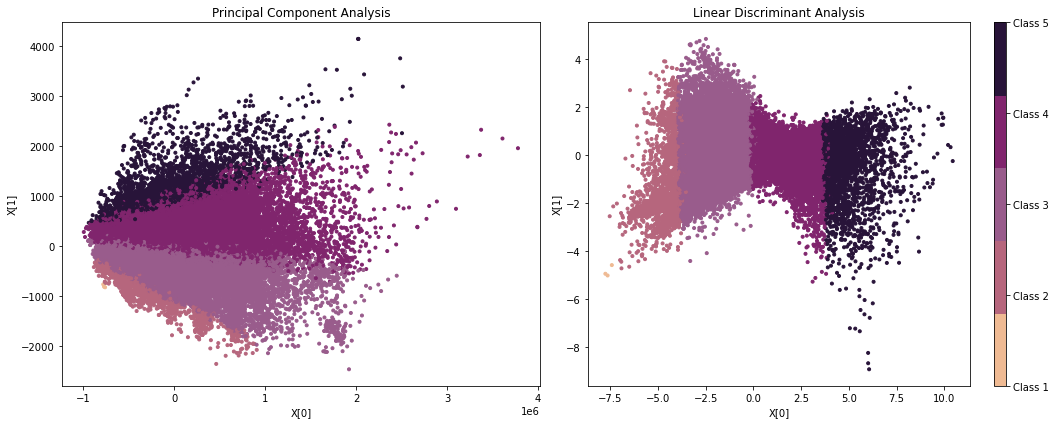

In [13]:
# display results after transformations
def plot_dimension_reduction():
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from matplotlib.colors import ListedColormap
    
    # lists for plotting
    c_map = ListedColormap(['#efba93', '#b6667d', '#995c8c', '#80256d', '#281439'])
    labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
    titles = ['Principal Component Analysis', 'Linear Discriminant Analysis']
    
    # dataset for PCA
    X = df.drop(['F3_cat'], axis=1).values
    X_pca = PCA(n_components=2).fit_transform(X)
    
    # dataset for LDA
    X.flat[::X.shape[1] + 1] += 0.01  # make X invertible
    X_lda = LinearDiscriminantAnalysis(solver='svd', n_components=4).fit_transform(X, df['F3_cat'].values)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    # PCA and LDA plots
    for ax, data, title in zip(axes.flat, [X_pca, X_lda], titles):
        pl = ax.scatter(x=data[:, 0], y=data[:, 1], c=df['F3_cat'], cmap=c_map, marker='.')
        ax.set_title(title)
        ax.set_xlabel('X[0]')
        ax.set_ylabel('X[1]')
    
    # shared colorbar
    cbar = fig.colorbar(pl, ticks=[1, 2, 3, 4, 5], aspect=30)
    cbar.ax.set_yticklabels(labels)
    
    plt.tight_layout()
    plt.show()
    
plot_dimension_reduction()

* The PCA plot displays non-linear behavior in the characteristics after reducing the dataset's dimensions. The scatter points strive for value near 0 (like a biplot) and onto the first principal component to maximize the variance. The algorithm does not reveal any unseen patterns or categories within the data.
* The LDA plot displays axes that maximize the separation between multiple classes. It maximizes the distance between the classes while minimizing the variation within each class. LDA is similar to regression analysis, which also attempt to express one dependent variable as a linear combination of other features or measurements.

For further data mining we should search for correlations between features individually. It was previously mentioned, that due to the number of low correlations between the target variable and the other attributes, we can add extra characteristics from combinations of attributes. We will look more closely at features: <code>F1</code>, <code>F2</code>, <code>F4</code>, <code>F5</code>, and <code>F6</code>. These columns are very well correlated with each other.

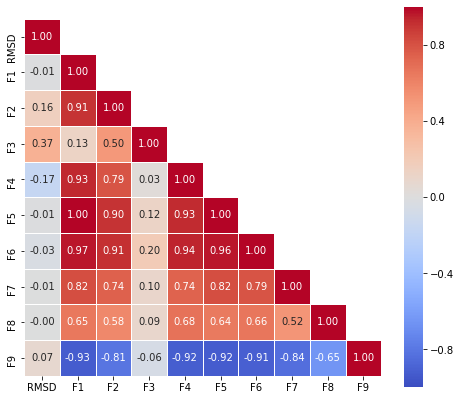

In [14]:
# heatmap
def plot_heatmap():
    from seaborn import heatmap
      
    # define correlation matrix
    corr_df = df.drop(['F3_cat'], axis=1).corr(method='pearson')
    df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
    
    # plot heatmap
    plt.figure(figsize=(8, 7))
    heatmap(data=df_lt, annot=True, square=True, cbar=True, vmin=-1, vmax=1, linewidths=0.5, fmt='0.2f', cmap='coolwarm')
    plt.show()
    
plot_heatmap()

Based on the results in the heatmap, we will create extra characteristics as following. We can choose attributes highly correlated with each other. For example, comparing decoy's fractional area of exposed non-polar part of residue (<code>F4</code>) with it's molecular mass of the exposed area (<code>F5</code>) makes sense.

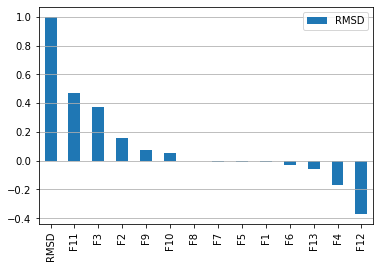

In [15]:
# new features
def generate_features():
    df['F10'] = df['F1']/df['F6']
    df['F11'] = df['F2']/df['F4']
    df['F12'] = df['F4']/df['F5']
    df['F13'] = df['F6']/df['F9']
    
generate_features()

# plot new correlations and display without 'F3_cat' feature
pd.DataFrame(df.drop(['F3_cat'], axis=1).corr(method='pearson')['RMSD'].sort_values(ascending=False)).plot.bar()
plt.grid(axis='y')
plt.show()

### 4. Stratified Sampling and Rescaling Data

To divide the dataset into training and test sets, we will implement stratified sampling. It is a sampling technique used to obtain samples that best represent the population. It reduces bias in selecting samples by dividing the population into homogeneous subgroups called strata. In addition, it is more robust. We will separate data into subgroups by the <code>F3_cat</code> column which we created ealier. The dataset will be partioned into training and validation sets with a 80:20 ratio.

For final transformations we will apply a pipeline. First step will standardize features with the <code>StandardScaler()</code> class by removing the mean and scaling to unit variance. The transformation shifts the values as given:

$$X_i' = \frac{X_i - mean(X)}{std(X)},$$

where $X_i$ is the original value, $mean(X)$ the mean value in feature range, and $std(X)$ the standard deviation.

The second step in the pipeline will reduce the dataset's dimensions with the PCA. Due to multicollinearity, our goal is to transform a number of correlated variables into a number of uncorrelated variables. We will set the variance of the input so that it will be explained by the generated components. Typically, we want the explained variance to be between 95–99%. This time it will be defined as 99%.

In [16]:
# perform data sampling
def sample_scale_dataset():
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)
    
    # create strata subsets
    for train_index, test_index in split.split(X=df, y=df['F3_cat']):
        strata_train_set = df.iloc[train_index]
        strata_test_set = df.iloc[test_index]
        
    # remove 'F3_cat' to give the original data
    for subset in (strata_train_set, strata_test_set):
        subset.drop(['F3_cat'], axis=1, inplace=True)
    
    X_train_, y_train_ = strata_train_set.drop(['RMSD'], axis=1), strata_train_set['RMSD']
    X_test_, y_test_ = strata_test_set.drop(['RMSD'], axis=1), strata_test_set['RMSD']
    
    # set pipeline
    pipeline = Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', PCA(n_components=0.99))])
    
    global X_train, X_test, y_train, y_test
    # rescale and reduce features via pipeline
    # feature array X
    X_train = pipeline.fit_transform(X_train_)
    X_test = pipeline.fit_transform(X_test_)
    # target data y
    y_train = pipeline.fit_transform(y_train_.values.reshape(-1, 1))
    y_test = pipeline.fit_transform(y_test_.values.reshape(-1, 1))
    
    print('Train Data: {}'.format(X_train.shape), '\nTest Data: {}'.format(X_test.shape))

sample_scale_dataset()

Train Data: (34838, 7) 
Test Data: (8710, 7)


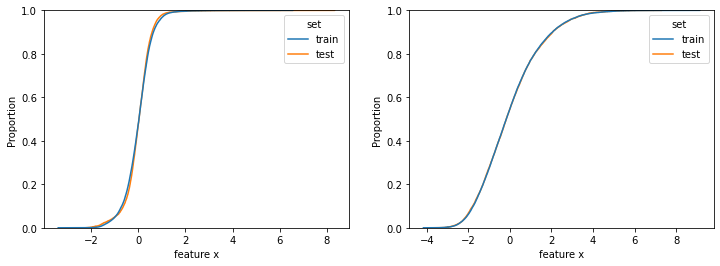

In [17]:
# visualize and investigate train-test dataset comparability
def plot_dataset_distribution():
    from seaborn import ecdfplot
    
    any_feature = 'feature x'
    # new subsets for visualizing
    df_1 = pd.DataFrame({any_feature: np.concatenate((X_train[:, 4], X_test[:, 4])),\
                       'set': ['train'] * X_train.shape[0] + ['test'] * X_test.shape[0]})
    
    df_2 = pd.DataFrame({any_feature: np.concatenate((X_train[:, 1], X_test[:, 1])),\
                       'set': ['train'] * X_train.shape[0] + ['test'] * X_test.shape[0]})
    
    plt.figure(figsize=(12, 4))
    
    # ECDF subplots
    for i, df in enumerate([df_1, df_2]):
        plt.subplot(1, 2, i+1)
        ecdfplot(data=df, x=any_feature, stat='proportion', hue='set')
    plt.show()
    
plot_dataset_distribution()

The empirical cumulative distribution plots give us a quick check of the sample distribution between training and validation subsets. In this case the curves overlay almost perfectly. The distribution of the chosen variables was not distorted in the stratified sampling.

### 5. Developing Regression Models

After data cleasning and sampling into training and validation subsets, we are ready to perform machine learning. Each model training will be preceded with hyperparameter tuning. We will develop functions for manual parameter searching in a stepwise approach, similar to the <code>GridSearchCV</code> class. The evaluation score for the optimal configuration will be the RMSE (root mean square error). Further estimators to built will be:
* artificial neural network (with <code>TensorFlow</code>),
* random forest,
* multi-layer perceptron,
* gradient boosting.

We will initialize a blank dataframe for storing our basic evaluation metrics. Each row will represent a separate model. A plotting function will be created to display the hyperparameter tuning results and for choosing optimum configurations.

In [18]:
# initialize dataframe to store evaluation metrics
model_scores = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2 Score'])

# function for plotting fitting results
def plot_rmse(dframe):
    """:dframe: pandas.core.frame.DataFrame"""
    
    colors = ['red' if (bar == dframe['RMSE'].min()) else 'steelblue' for bar in dframe['RMSE']]
    dframe.plot.bar(x='Trial', y='RMSE', figsize=(10, 4), color=colors)
    plt.ylim(bottom=dframe['RMSE'].min() - 0.02, top=dframe['RMSE'].max() + 0.02)
    plt.xticks(rotation=0)
    plt.show()

#### 5a. Artificial Neural Network

Expected Fits: 18
========== Artificial Neural Network Results ==========

1.	Parameters: batch size = 15,	epochs = 10,	optimizer = adam,	RMSE = 0.6904
2.	Parameters: batch size = 15,	epochs = 10,	optimizer = rmsprop,	RMSE = 0.7254
3.	Parameters: batch size = 15,	epochs = 20,	optimizer = adam,	RMSE = 0.6738
4.	Parameters: batch size = 15,	epochs = 20,	optimizer = rmsprop,	RMSE = 0.6978
5.	Parameters: batch size = 15,	epochs = 50,	optimizer = adam,	RMSE = 0.6794
6.	Parameters: batch size = 15,	epochs = 50,	optimizer = rmsprop,	RMSE = 0.6892
7.	Parameters: batch size = 20,	epochs = 10,	optimizer = adam,	RMSE = 0.6868
8.	Parameters: batch size = 20,	epochs = 10,	optimizer = rmsprop,	RMSE = 0.7024
9.	Parameters: batch size = 20,	epochs = 20,	optimizer = adam,	RMSE = 0.6759
10.	Parameters: batch size = 20,	epochs = 20,	optimizer = rmsprop,	RMSE = 0.6945
11.	Parameters: batch size = 20,	epochs = 50,	optimizer = adam,	RMSE = 0.6805
12.	Parameters: batch size = 20,	epochs = 50,	optimizer = rms

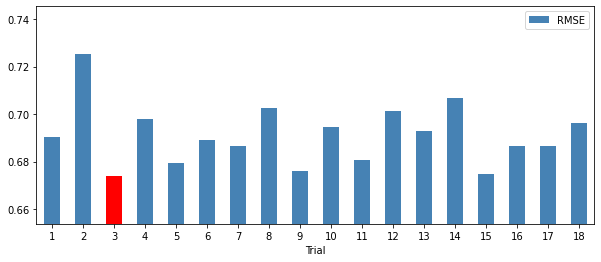

In [19]:
# 1. hyperparameter tuning
def ann_best_paramaters():
    from keras.models import Sequential
    from keras.layers import Dense
    from sklearn.metrics import mean_squared_error
    
    ######### initialize list variables
    batch_size_list = [15, 20, 25]
    epoch_list = [10, 20, 50]
    optimizer_list = ['adam', 'rmsprop']
    
    # define dataframe for results
    search_results = pd.DataFrame(columns=['Trial', 'RMSE'])
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(batch_size_list) * len(epoch_list) * len(optimizer_list)))
    print('========== Artificial Neural Network Results ==========\n')
    count = 0
    for batch_size in batch_size_list:
        for epochs_ in epoch_list:
            for optimizer in optimizer_list:
                count += 1
                
                # define ANN model
                network = Sequential()
                network.add(Dense(units=200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
                network.add(Dense(units=100, kernel_initializer='normal', activation='relu'))
                network.add(Dense(units=1, kernel_initializer='normal'))
 
                # compile and fit model
                network.compile(loss='mean_squared_error', optimizer=optimizer)
                network.fit(X_train, y_train, batch_size=batch_size, epochs=epochs_, verbose=0)
                
                rmse = mean_squared_error(y_test, network.predict(X_test), squared=False)
            
                # verbose for each iteration
                print('{}.\tParameters: batch size = {},\tepochs = {},\toptimizer = {},\tRMSE = {:.4f}'\
                      .format(count, batch_size, epochs_, optimizer, rmse))
                
                # append each trial row to the dataframe
                search_results = search_results.append(pd.DataFrame(data=[[count, rmse]], columns=['Trial', 'RMSE']))
                
    return search_results

# dataframe with scores
ann_results = ann_best_paramaters()

# plot results
plot_rmse(dframe=ann_results)

* These results conclude that the Adam optimization algorithm works best with our ANN. The RMSE values seem to be best for 20 epochs.

In [20]:
# 2. build estimator with best parameters
def ann_regressor():
    from keras.models import Sequential
    from keras.layers import Dense
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # dictionary with optimum parameters
    params = {'batch_size': 15, 'epochs': 20, 'optimizer': 'adam'}
    
    # define ANN model
    network = Sequential(name='ANN')
    network.add(Dense(units=200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    network.add(Dense(units=200, kernel_initializer='normal', activation='tanh'))
    network.add(Dense(units=1, kernel_initializer='normal'))

    # compile and fit model
    network.compile(loss='mean_squared_error', optimizer=params['optimizer'])
    network.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
    
    # regression metrics
    mae = mean_absolute_error(y_test, network.predict(X_test))
    rmse = mean_squared_error(y_test, network.predict(X_test), squared=False)
    r2 = r2_score(y_test, network.predict(X_test))
    
    global ann_row
    ann_row = {'Model': network.name, 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

# run new estimator
ann_regressor()

# append results to dataframe
model_scores = model_scores.append(ann_row, ignore_index=True)

#### 5b. Random Forest

Expected Fits: 24
========== Random Forest Results ==========

1.	Parameters: estimators = 100,	max depth = 10,	bootstrap = True,	RMSE = 0.7106
2.	Parameters: estimators = 100,	max depth = 20,	bootstrap = True,	RMSE = 0.6483
3.	Parameters: estimators = 100,	max depth = 30,	bootstrap = True,	RMSE = 0.6449
4.	Parameters: estimators = 100,	max depth = None,	bootstrap = True,	RMSE = 0.6446
5.	Parameters: estimators = 100,	max depth = 10,	bootstrap = False,	RMSE = 0.7725
6.	Parameters: estimators = 100,	max depth = 20,	bootstrap = False,	RMSE = 0.8515
7.	Parameters: estimators = 100,	max depth = 30,	bootstrap = False,	RMSE = 0.8737
8.	Parameters: estimators = 100,	max depth = None,	bootstrap = False,	RMSE = 0.8733
9.	Parameters: estimators = 200,	max depth = 10,	bootstrap = True,	RMSE = 0.7097
10.	Parameters: estimators = 200,	max depth = 20,	bootstrap = True,	RMSE = 0.6474
11.	Parameters: estimators = 200,	max depth = 30,	bootstrap = True,	RMSE = 0.6434
12.	Parameters: estimators = 200,	ma

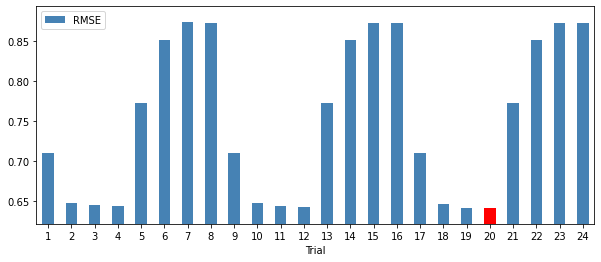

In [21]:
# 1. hyperparameter tuning
def rf_best_paramaters():
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    
    ######### initialize list variables
    estimators_list = [100, 200, 400]
    bootstrap_list = [True, False]
    max_depth_list = [10, 20, 30, None]
    
    # define dataframe for results
    search_results = pd.DataFrame(columns=['Trial', 'RMSE'])
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(estimators_list) * len(bootstrap_list) * len(max_depth_list)))
    print('========== Random Forest Results ==========\n')
    count = 0
    for estimators in estimators_list:
        for bootstrap_ in bootstrap_list:
            for max_depth_ in max_depth_list:
                
                count += 1
                
                # define model
                rf = RandomForestRegressor(n_estimators=estimators, bootstrap=bootstrap_, max_depth=max_depth_,
                                           random_state=42)
                rf.fit(X_train, y_train)
                
                rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
            
                # verbose for each iteration
                print('{}.\tParameters: estimators = {},\tmax depth = {},\tbootstrap = {},\tRMSE = {:.4f}'\
                      .format(count, estimators, max_depth_, bootstrap_, rmse))
                
                # append each trial row to the dataframe
                search_results = search_results.append(pd.DataFrame(data=[[count, rmse]], columns=['Trial', 'RMSE']))
                
    return search_results
 
# dataframe with scores
rf_results = rf_best_paramaters()

# plot results
plot_rmse(dframe=rf_results)

* The key parameter for this case seems to be the maximum depth of the tree. A higher number of trees (estimators) does not necessarily benefit the learning score as expected. It is interesting to observe how the RMSE gradually increases with each higher <code>max_depth</code>.

In [22]:
# 2. build estimator with best parameters
def rf_regressor():
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # dictionary with optimum parameters
    params = {'n_estimators': 400, 'bootstrap': True, 'max_depth': None, 'random_state': 42}
    
    # compile and fit model
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    
    # regression metrics
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
    r2 = r2_score(y_test, rf.predict(X_test))
    
    global rf_row
    rf_row = {'Model': type(rf).__name__.replace('Regressor', ''), 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

# run new estimator
rf_regressor()

# append results to dataframe
model_scores = model_scores.append(rf_row, ignore_index=True)

#### 5c. Multi-layer Perceptron

Expected Fits: 12
========== Multi-layer Perceptron Results ==========

1.	Parameters: layer size = (50, 50, 50),	optimizer = tanh,	iterations = 100,	RMSE = 0.6800
2.	Parameters: layer size = (50, 50, 50),	optimizer = tanh,	iterations = 200,	RMSE = 0.6890
3.	Parameters: layer size = (50, 50, 50),	optimizer = relu,	iterations = 100,	RMSE = 0.6863
4.	Parameters: layer size = (50, 50, 50),	optimizer = relu,	iterations = 200,	RMSE = 0.6764
5.	Parameters: layer size = (50, 100, 50),	optimizer = tanh,	iterations = 100,	RMSE = 0.6709
6.	Parameters: layer size = (50, 100, 50),	optimizer = tanh,	iterations = 200,	RMSE = 0.6966
7.	Parameters: layer size = (50, 100, 50),	optimizer = relu,	iterations = 100,	RMSE = 0.6679
8.	Parameters: layer size = (50, 100, 50),	optimizer = relu,	iterations = 200,	RMSE = 0.6897
9.	Parameters: layer size = (100,),	optimizer = tanh,	iterations = 100,	RMSE = 0.7324
10.	Parameters: layer size = (100,),	optimizer = tanh,	iterations = 200,	RMSE = 0.7238
11.	Parameters:

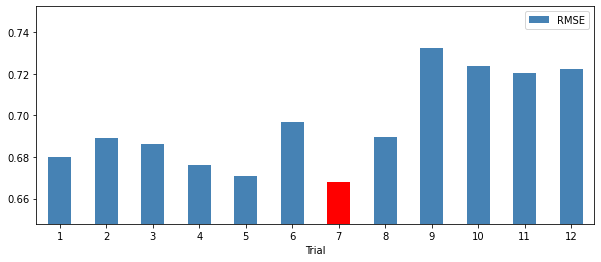

In [23]:
# 1. hyperparameter tuning
def mlp_best_paramaters():
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import mean_squared_error
    
    ######### initialize list variables
    hidden_layer_list = [(50, 50, 50), (50, 100, 50), (100,)]
    function_list = ['tanh', 'relu']
    iteration_list = [100, 200]
    
    # define dataframe for results
    search_results = pd.DataFrame(columns=['Trial', 'RMSE'])
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(hidden_layer_list) * len(function_list) * len(iteration_list)))
    print('========== Multi-layer Perceptron Results ==========\n')
    count = 0
    for layer_size in hidden_layer_list:
        for function in function_list:
            for max_iter_ in iteration_list:
                
                count += 1
                
                # define model
                mlp = mlp = MLPRegressor(activation=function, alpha= 0.001, hidden_layer_sizes=layer_size,
                                          learning_rate='adaptive', solver='adam', max_iter=max_iter_, random_state=42)
                mlp.fit(X_train, y_train)
                
                rmse = mean_squared_error(y_test, mlp.predict(X_test), squared=False)
            
                # verbose for each iteration
                print('{}.\tParameters: layer size = {},\toptimizer = {},\titerations = {},\tRMSE = {:.4f}'\
                      .format(count, layer_size, function, max_iter_, rmse))
                
                # append each trial row to the dataframe
                search_results = search_results.append(pd.DataFrame(data=[[count, rmse]], columns=['Trial', 'RMSE']))
                
    return search_results

# dataframe with scores
mlp_results = mlp_best_paramaters()

# plot results
plot_rmse(dframe=mlp_results)

* The ReLU (rectified linear unit) activation function is the best choice for this task which should not come in surprise. This optimizer has linear behavior and is recommended as the default for MLP. The above chart shows that less hidden layers return worse results - last four fits in our case.

In [24]:
# 2. build estimator with best parameters
def mlp_regressor():
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # dictionary with optimum parameters
    params = {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive',
              'solver': 'adam', 'max_iter': 100, 'random_state': 42}
    
    # compile and fit model
    mlp = MLPRegressor(**params)
    mlp.fit(X_train, y_train)

    # regression metrics
    mae = mean_absolute_error(y_test, mlp.predict(X_test))
    rmse = mean_squared_error(y_test, mlp.predict(X_test), squared=False)
    r2 = r2_score(y_test, mlp.predict(X_test))
    
    global mlp_row
    mlp_row = {'Model': type(mlp).__name__.replace('Regressor', ''), 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

# run new estimator
mlp_regressor()

# append results to dataframe
model_scores = model_scores.append(mlp_row, ignore_index=True)

#### 5d. Gradient Boosting

Expected Fits: 24
========== Gradient Boosting Results ==========

1.	Parameters: estimators = 100,	max depth = 6,	max features = auto,	RMSE = 0.7011
2.	Parameters: estimators = 100,	max depth = 7,	max features = auto,	RMSE = 0.6828
3.	Parameters: estimators = 100,	max depth = 8,	max features = auto,	RMSE = 0.6742
4.	Parameters: estimators = 100,	max depth = 9,	max features = auto,	RMSE = 0.6647
5.	Parameters: estimators = 100,	max depth = 6,	max features = sqrt,	RMSE = 0.7133
6.	Parameters: estimators = 100,	max depth = 7,	max features = sqrt,	RMSE = 0.6942
7.	Parameters: estimators = 100,	max depth = 8,	max features = sqrt,	RMSE = 0.6759
8.	Parameters: estimators = 100,	max depth = 9,	max features = sqrt,	RMSE = 0.6687
9.	Parameters: estimators = 200,	max depth = 6,	max features = auto,	RMSE = 0.6894
10.	Parameters: estimators = 200,	max depth = 7,	max features = auto,	RMSE = 0.6770
11.	Parameters: estimators = 200,	max depth = 8,	max features = auto,	RMSE = 0.6720
12.	Parameters: es

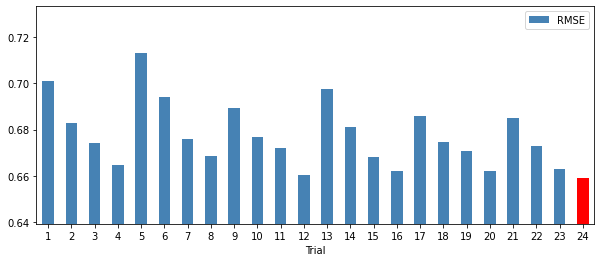

In [25]:
# 1. hyperparameter tuning
def gb_best_paramaters():
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.metrics import mean_squared_error
    
    ######### initialize list variables
    estimators_list = [100, 200, 400]
    max_features_list = ['auto', 'sqrt']
    max_depth_list = [6, 7, 8, 9]
    
    # define dataframe for results
    search_results = pd.DataFrame(columns=['Trial', 'RMSE'])
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(estimators_list) * len(max_features_list) * len(max_depth_list)))
    print('========== Gradient Boosting Results ==========\n')
    count = 0
    for estimators in estimators_list:
        for max_features_ in max_features_list:
            for max_depth_ in max_depth_list:
                
                count += 1
                
                # define model
                gb = GradientBoostingRegressor(n_estimators=estimators, random_state=42, max_features=max_features_,
                                           max_depth=max_depth_)
                gb.fit(X_train, y_train)
                
                rmse = mean_squared_error(y_test, gb.predict(X_test), squared=False)
            
                # verbose for each iteration
                print('{}.\tParameters: estimators = {},\tmax depth = {},\tmax features = {},\tRMSE = {:.4f}'\
                      .format(count, estimators, max_depth_, max_features_, rmse))
                
                # append each trial row to the dataframe
                search_results = search_results.append(pd.DataFrame(data=[[count, rmse]], columns=['Trial', 'RMSE']))
                
    return search_results
 
# dataframe with scores
gb_results = gb_best_paramaters()

# plot results
plot_rmse(dframe=gb_results)

* Similarly as for the random forest regressor, this algorithm depends greatly on the maximum depth of the estimator - higher depth results in lower loss. The number of features to consider (<code>max_features</code> argument) does not have significant impact for the final scores.

In [26]:
# 2. build estimator with best parameters
def gb_regressor():
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # dictionary with optimum parameters
    params = {'n_estimators': 400, 'max_depth': 9, 'max_features': 'sqrt', 'random_state': 42}
    
    # compile and fit model
    gb = GradientBoostingRegressor(**params)
    gb.fit(X_train, y_train)

    # regression metrics
    mae = mean_absolute_error(y_test, gb.predict(X_test))
    rmse = mean_squared_error(y_test, gb.predict(X_test), squared=False)
    r2 = r2_score(y_test, gb.predict(X_test))
    
    global gb_row
    gb_row = {'Model': type(gb).__name__.replace('Regressor', ''), 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

# run new estimator
gb_regressor()

# append results to dataframe
model_scores = model_scores.append(gb_row, ignore_index=True)

### 6. Visualizing Model Performance

We trained our regressors successively. Each model was preceded by finding optimal hyperparameters for higher performance. We will evaluate their performances and usefulness, compare them, and choose the best algorithm.

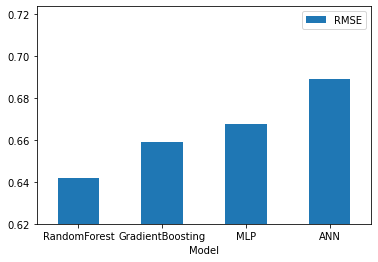

Model,MAE,RMSE,R2 Score
RandomForest,0.466395,0.641751,0.588156
GradientBoosting,0.485399,0.659230,0.565416
MLP,0.488006,0.667914,0.553890
ANN,0.505709,0.689411,0.524713


In [27]:
# display achieved RMSE for each regressor
pd.DataFrame(model_scores[['RMSE', 'Model']].set_index('Model').sort_values(by='RMSE', ascending=True)).plot.bar()
plt.ylim(bottom=0.62)
plt.xticks(rotation=0)
plt.show()

# table of metrics
model_scores.sort_values(by='RMSE', ascending=True).style.hide_index()

In terms of overall metrics the random forest performed the best. The worst performance is for <code>TensorFlow</code> neural network.

The last step of this notebook will be displaying training curves for the best machine learning model. These curves show how the the model benefits from adding more training data and help determine the amount of data used for training. We will define MSE (mean squared error) as the minimizing metric, meaning that smaller relative scores indicate more or better learning. We will perform 5-fold cross validation for obtaining validation scores to plot on the graph.

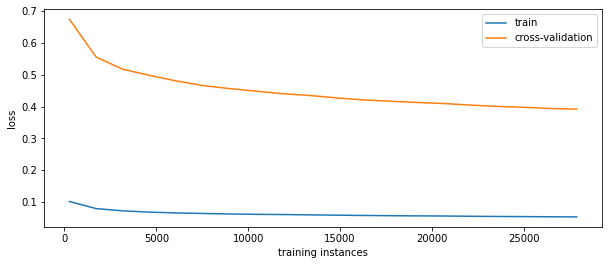

In [28]:
# plot learning curves for best model
def plot_learning_curves():
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import learning_curve
    
    params = {'n_estimators': 400, 'bootstrap': True, 'max_depth': None, 'random_state': 42}
    
    # get scores from learning_curve function
    sizes, train_scores, test_scores = learning_curve(RandomForestRegressor(**params), X_train, y_train, cv=5, 
                                                      scoring='neg_mean_squared_error',
                                                      train_sizes=np.linspace(0.01, 1.0, 20))
    
    # mean and standard deviation of training scores
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
  
    # mean and standard deviation of testing scores
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    
    # plot learning curves
    plt.figure(figsize=(10, 4))
    plt.plot(sizes, -mean_train_scores, label='train')
    plt.plot(sizes, -mean_test_scores, label='cross-validation')
    plt.xlabel('training instances')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
plot_learning_curves()

The error gradualy decreases for each new amount of data but the loss is not good. The validation loss is high which indicates that the model does not generalize to unseen data and the model is overfitting. It's loss function might be robust on the training dataset, but it suffers when we evaluate it on the cross-validation set. The training dataset is easier to predict than the cross-validation subset. The large gap between the curves might indicate high variance.

### 7. Summary

The main line of this notebook was to perform a regression task to estimate residue size for each protein of a CASP dataset. The task was completed and we developed four predictive models, yet none of them seem to be accurate enough for this dataset. We noticed previously that the input physicochemical properties were not correlated well with our target data. To overcome this issue, we created additional features by combining the existing ones. We also spotted multicollinearity in the matrix of scatter plots and decided to apply PCA with 99% explained variance to eliminate this problem. Finally, we preceded each compiling process with model tuning and still achieved overall moderate scores.

After trying different supervised machine learning algorithms to estimate residues of amino acids, we can state that the **random forest** still evaluated the best. Perhaps more knowledge of molecular biology and macromolecules would improve the model accuracy (for example choosing more suitable properties to perform regression, or implementing other data transformations).